## **MA5606 Tópicos Matemáticos en Aprendizaje de Máquinas, Redes Neuronales y Aprendizaje Profundo**

# **DeepONets**

Este notebook busca mostrar un ejemplo sencillo de DeepONets, aplicado a aprender el operador $G: C([0, 1]) \times [0, 1] \to \mathbb{R}$ definido por

$$ G(u, x) = \int_0^x u(s) ds $$

Para ello utilizaremos DeepXDE, que facilita todos los detalles técnicos asociados a armar la red (que tiene una arquitectura un poco diferente a las feedforward vistas antes).

Para ello comencemos instalando la librería.

In [ ]:
# Instalar DeepXDE
try:
    import deepxde as dde
except:
    !pip install deepxde
    import deepxde as dde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 6.3 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


E importando otras librerías que necesitaremos.

In [ ]:
# Otras librerías
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.integrate import cumtrapz
from sklearn.gaussian_process.kernels import RBF

Ahora debemos generar datos para poder entrenar la red, es decir, necesitamos funciones $u \in C([0,1])$ dadas para poder crear otras funciones $v$ definidas por

$$ v(x) = G(u,y) = \int_0^x u(s) ds $$

En otras palabras, necesitamos la función a integrar y el valor de la integral en cada punto. ¿Y cómo podemos generar muchas funciones de manera rápida? La solución más eficiente y que no tiene un sesgo significativo respecto a la forma de la función es samplear una función desde un proceso gaussiano.

Esto es lo siguiente, si tengo una discretización $X = \{ x_i \}_{i=1}^N$ del intervalo $[0, 1]$, entonces una función $u$ es sampleada desde un proceso gaussiano representado por los $X$ si

$$ u(X) \sim N( 0_{N \times N}, k(X, X)) $$

Donde $k$ es lo que se llama una función *kernel*, en este caso $k: [0, 1] \times [0, 1] \to \mathbb{R}$ dada por

$$ k(x, y) = \text{exp} (- |x-y|^2/(2 \sigma^2)) $$

Que se denota por *kernel* gaussiano o RBF. Por tanto $k(X, X)$ actúa como matriz de covarianzas

$$ k(X, X)_{ij} = k(x_i, x_j) $$

Con esto veamos como samplear funciones aleatorias con Python.

In [ ]:
# Sampleo desde un proceso gaussiano
Npoints = 100  # Cantidad de puntos en cada trayectoria
Ntraj_train = 150  # Cantidad de trayectorias de entrenamiento
Ntraj_test = 300  # Cantidad de trayectorias de testeo

# Puntos a samplear en [0, 1]
x0, xf = 0, 1
xdim = 1

# Arreglo sin expandir
x = np.linspace(0, 1, Npoints)

# Arreglo expandido
X = np.expand_dims(np.linspace(x0, xf, Npoints), xdim)

print("Tamaño arreglo sin expandir:", x.shape)
print("Tamaño arreglo expandido:", X.shape)

Tamaño arreglo sin expandir: (100,)
Tamaño arreglo expandido: (100, 1)


Utilizamos el kernel gaussiano creado por Sklearn y creamos la matriz de covarianzas.

In [ ]:
# Kernel gaussiano
kernel = RBF(0.25)

# Matriz de covarianzas dada por el kernel
Sigma = kernel.__call__(X, X)

Veamos como se ve el kernel en el intervalo $[0,1]$.

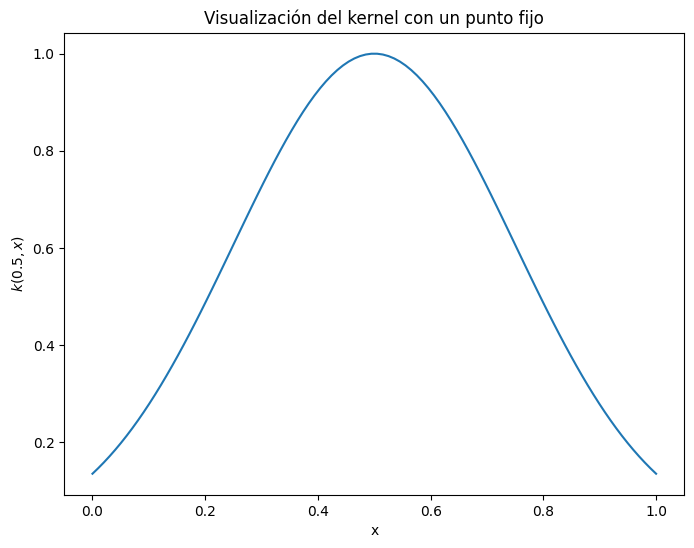

In [ ]:
# Punto fijo con respecto a que calcular el kernel, solo para visualizar
center = 0.5

# Imagen del kernel a través del punto fijo y todo el intervalo [0, 1]
ker_img = kernel.__call__(np.array([[center]]), X).reshape(len(x))

# Gráfico
plt.figure(figsize=(8, 6))
plt.plot(x, ker_img)
plt.xlabel("x")
plt.ylabel(r"$k({}, x)$".format(center))
plt.title("Visualización del kernel con un punto fijo")
plt.show()

Veamos como se ve la matriz de covarianzas.

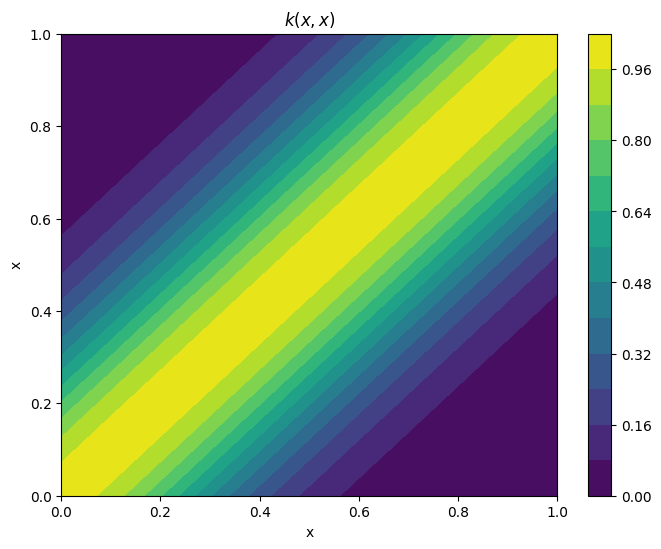

In [ ]:
# Gráfico
X1, X2 = np.meshgrid(x, x)

fig = plt.figure(figsize=(8,6))
c = plt.contourf(X1, X2, Sigma, levels=15)
plt.xlabel("x")
plt.ylabel("x")
plt.title(r"$k(x,x)$")
cbar = fig.colorbar(c)
plt.show()

Ahora generaremos las funciones (o trayectorias) sampleadas desde un proceso gaussiano.

In [ ]:
# Sampleo desde una normal multivariada para simular el proceso

# Entrenamiento
gpr_train = np.random.multivariate_normal(
    mean=np.zeros(Npoints),
    cov=Sigma,
    size=Ntraj_train)

# Testeo
gpr_test = np.random.multivariate_normal(
    mean=np.zeros(Npoints),
    cov=Sigma,
    size=Ntraj_test)

Veamos una de las trayectorias sampleadas.

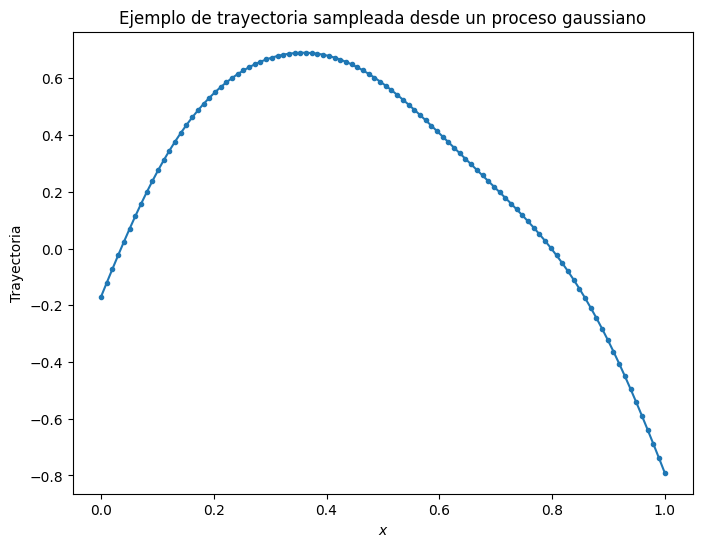

In [ ]:
# Gráfico
plt.figure(figsize=(8, 6))
plt.plot(X, gpr_train[0], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$')
plt.ylabel('Trayectoria')
plt.title("Ejemplo de trayectoria sampleada desde un proceso gaussiano")
plt.show()

Ahora graficamos todas las trayectorias que se usarán para entrenar a la red.

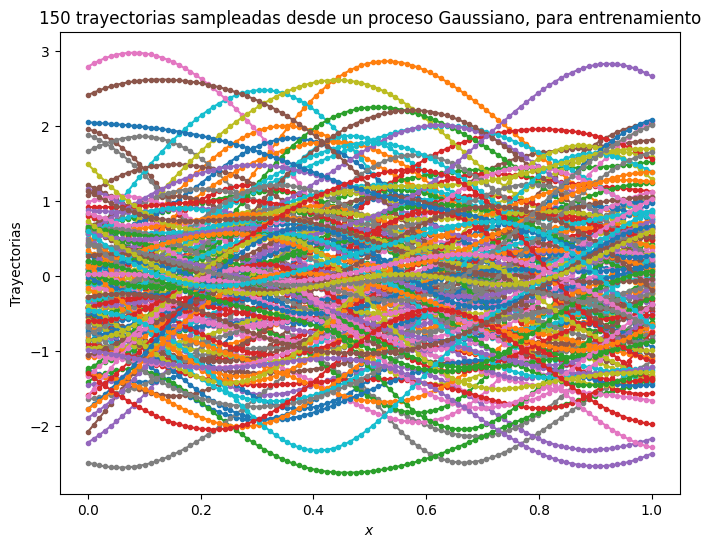

In [ ]:
# Gráfico
plt.figure(figsize=(8, 6))

for i in range(Ntraj_train):
    plt.plot(X, gpr_train[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$')
plt.ylabel('Trayectorias')
plt.title("{} trayectorias sampleadas desde un proceso Gaussiano, para entrenamiento".format(Ntraj_train))
plt.show()

Después calculamos las integrales en todos los puntos de la discretización, para todas las trayectorias.

In [ ]:
# Trayectorias integradas, entrenamiento
int_traj_train = cumtrapz(gpr_train, x, axis=1, initial=0)

# Trayectorias integradas, testeo
int_traj_test = cumtrapz(gpr_test, x, axis=1, initial=0)

In [ ]:
# Dataset para entrenar
X_train = (gpr_train, X)
y_train = int_traj_train

# Dataset para testear
X_test = (gpr_test, X)
y_test = int_traj_test

# Juntamos todos los dataset en un formato que DeepXDE dispone para las DeepONets
data = dde.data.TripleCartesianProd(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)

Compiling model...
Building DeepONetCartesianProd...
'build' took 0.087404 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/deeponet.py:549: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y_func = tf.layers.dense(
/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/deeponet.py:556: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y_func = tf.layers.dense(
/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/deeponet.py:570: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y_loc = tf.layers.dense(


'compile' took 0.298794 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [6.03e-01]    [6.74e-01]    [2.20e+00]    
1000      [2.05e-03]    [2.67e-03]    [1.76e-01]    
2000      [1.50e-03]    [1.83e-03]    [1.50e-01]    
3000      [5.01e-04]    [7.69e-04]    [9.56e-02]    
4000      [3.75e-04]    [5.64e-04]    [8.25e-02]    
5000      [3.18e-04]    [4.74e-04]    [7.54e-02]    
6000      [2.67e-04]    [3.99e-04]    [6.93e-02]    
7000      [2.03e-04]    [3.44e-04]    [6.22e-02]    
8000      [1.42e-04]    [2.74e-04]    [5.29e-02]    
9000      [8.26e-05]    [2.26e-04]    [4.45e-02]    
10000     [9.82e-05]    [2.56e-04]    [4.60e-02]    
11000     [5.14e-04]    [7.14e-04]    [8.38e-02]    
12000     [5.03e-05]    [1.91e-04]    [3.88e-02]    
13000     [5.15e-05]    [2.01e-04]    [3.86e-02]    
14000     [1.98e-04]    [3.84e-04]    [5.55e-02]    
15000     [4.11e-05]    [1.75e-04]    [3.61e-02]    
16000     [4.35e-05]    [1.84e-04]    [3.69e-02]    


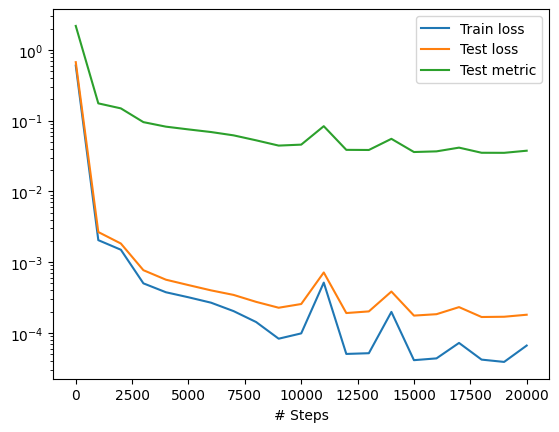

In [ ]:
# Armamos la red

# Dimensión para la branch net
n_branch = 40

# Dimensión para la trunk net
n_trunk = 40

# Red con Tanh e iniciación Glorot
net = dde.nn.DeepONetCartesianProd(
    [Npoints, n_branch, n_branch],
    [xdim, n_trunk, n_trunk],
    "tanh",
    "Glorot normal",
)

# Modelo
model = dde.Model(data, net)

# Compilación y entrenamiento
model.compile("adam", lr=0.001, metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

# Plot the loss trajectory
dde.utils.plot_loss_history(losshistory)
plt.show()

Ahora testeamos con funciones coseno de distinta frecuencia.

In [ ]:
# Testeamos con una función conocida
f = lambda x, w: np.cos(w*x)
f_int = lambda x, w: np.sin(w*x)/w

In [ ]:
# Cantidad de funciones a testear
n_test = 5
fun_test = np.zeros((n_test, Npoints))
fun_test_int = np.zeros((n_test, Npoints))

# Frecuencias a probar
omegas = np.linspace(1, 2*np.pi, n_test)

# Se calcula cada una
for i in range(n_test):
    fun_test[i] = f(x, omegas[i])
    fun_test_int[i] = f_int(x, omegas[i])

In [ ]:
# Arreglo disminuido para poder evaluar
x_arr = np.expand_dims(x, axis=-1)

# Predicción del modelo
y_pred = model.predict((fun_test, x_arr)).reshape((n_test, Npoints))

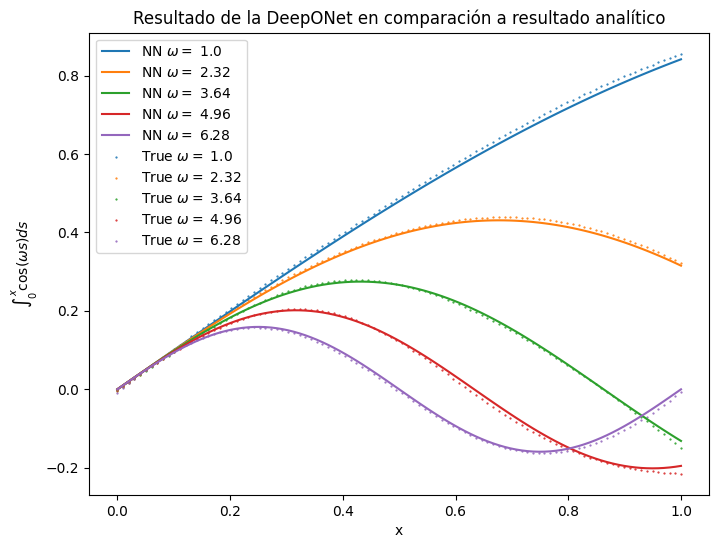

In [ ]:
# Label para las funciones reales
lab_true = [r"NN $\omega=$ {}".format(round(omegas[i],2)) for i in range(len(omegas))]

# Gráfico
plt.figure(figsize=(8,6))
plt.plot(x, fun_test_int.T, label=lab_true)
for i in range(n_test):
    plt.scatter(x, y_pred[i], label=r"True $\omega = $ {}".format(round(omegas[i], 2)), s=0.3)
plt.xlabel("x")
plt.ylabel(r"$\int_0^x \cos (\omega s) ds$")
plt.title("Resultado de la DeepONet en comparación a resultado analítico")
plt.legend()
plt.show()